In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

warnings.filterwarnings(action='ignore')

In [23]:
# Load dataset and display top 5 rows

df_covid=pd.read_csv("us_counties_covid19_daily.csv")
df_covid.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0
3,2020-01-24,Cook,Illinois,17031.0,1,0.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0


In [24]:
df_covid.tail()

,date,county,state,fips,cases,deaths
800432,2020-12-05,Sweetwater,Wyoming,56037.0,2098,10.0
800433,2020-12-05,Teton,Wyoming,56039.0,1739,2.0
800434,2020-12-05,Uinta,Wyoming,56041.0,1187,5.0
800435,2020-12-05,Washakie,Wyoming,56043.0,519,8.0
800436,2020-12-05,Weston,Wyoming,56045.0,419,2.0


# EDA


In [25]:
# Discover missing values

df_covid.isnull().sum()

date          0
county        0
state         0
fips       7591
cases         0
deaths    16733
dtype: int64

In [26]:
# Fill missing values with median

# method = 'pad' 바로 앞에꺼 값을 결측치로 대체하는 것
# mean 보다 median이 이상치의 영향을 덜 받는 특징때문에 median을 사용했다.

df_covid['fips'] = df_covid['fips'].fillna(method = 'pad')# The values of 'fips' are mostly similiar to values next to each other 
df_covid['deaths'] = df_covid['deaths'].fillna(df_covid['deaths'].median())

In [28]:
# 시각화를 위해서 결측치 제거전 df를  미리 만들어 놓기 
df = df_covid

In [6]:
# drop death, fips variable ( death는 예측하려는 변수가 아니여서 제거, fips는 state와 일치하는 변수임으로 제거)
df_covid = df_covid.drop('deaths', axis=1, inplace=False)
df_covid = df_covid.drop('fips', axis=1, inplace=False)

In [7]:
# check missing values again

df_covid.isnull().sum()

date      0
county    0
state     0
cases     0
dtype: int64

In [8]:
# Discover data type

df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800437 entries, 0 to 800436
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    800437 non-null  object
 1   county  800437 non-null  object
 2   state   800437 non-null  object
 3   cases   800437 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 24.4+ MB


In [10]:
df_covid.describe()

,cases
count,800437.000000
mean,1589.667358
std,8385.201329
min,0.000000
25%,29.000000
50%,175.000000
75%,775.000000
max,439538.000000


In [11]:
df_covid.cases


0            1
1            1
2            1
3            1
4            1
          ... 
800432    2098
800433    1739
800434    1187
800435     519
800436     419
Name: cases, Length: 800437, dtype: int64

# Distribution

<AxesSubplot:title={'center':'Target: covid cases'}, xlabel='cases', ylabel='Density'>

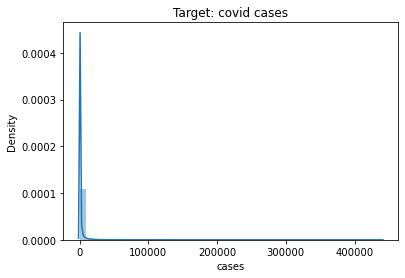

In [12]:
# Original target variable histogram

plt.title('Target: covid cases')
sns.distplot(df_covid['cases'])

<AxesSubplot:title={'center':'Log Transformed Target: covid cases'}, xlabel='cases', ylabel='Density'>

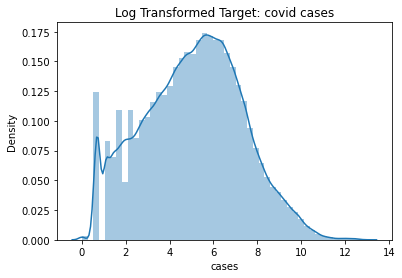

In [15]:
# Log transformed target variable histogram

log_covid = np.log1p(df_covid['cases'])

plt.title('Log Transformed Target: covid cases')
sns.distplot(log_covid)

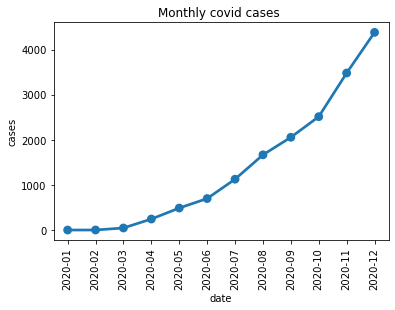

In [13]:
# Discover monthly covid cases

df_date = df_covid[['date', 'cases']].copy()
df_date.date = pd.to_datetime(df_date.date) 
df_date.set_index('date', inplace=True)
df_date = df_date.resample('MS').mean().reset_index()

plt.title("Monthly covid cases ")
labels = df_date.date.dt.to_period('M')
date_plot = sns.pointplot(data=df_date, x='date', y='cases').set_xticklabels(rotation=90, labels=labels)

In [ ]:
fig,(ax1,ax2,ax3)= plt.subplots(nrows=3)
fig.set_size_inches(15,8)

sns.scatterplot(data=df_date, x='date', y='cases', ax=ax1).set_xticklabels(rotation=90, labels=labels)

sns.scatterplot(data=df_county, x='county', y='cases', ax=ax2)..set_xticklabels(rotation=90, labels=labels)

sns.scatterplot(data=df_state, x='state', y='cases', hue='state', ax=ax3).set_xticklabels(rotation=90, labels=labels)


<AxesSubplot:>

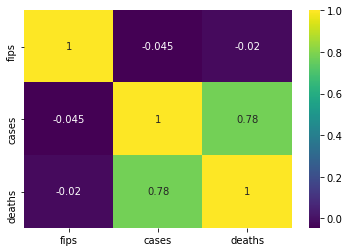

In [29]:
# fips 와 death의 변수의 제거가 맞는지 확인하기 위해서 그래프를 그렸다.

sns.heatmap(df.corr(), annot = True, cmap = 'viridis')

fips 와 death는 case 변수와의 상관관계가 각각 -0.045,-0.02 로 매우 낮음을 보여주기 때문에 제거했음이 맞음을 알 수 있다

# Preprocessing

In [30]:
# Test data transformation (get dummy variables from date variable)

def preprocess(df):
    # To right date format
    df2 = df.copy()
    df2.date = df2.date.apply(pd.to_datetime)
    df2['year'] = df2.date.apply(lambda x: x.year)
    df2['month'] = df2.date.apply(lambda x: x.month)
    df2['day'] = df2.date.apply(lambda x: x.day)
    df2.drop(['date'], axis=1, inplace=True)
    
    #original_target = df2['cases']
    #df2['case'] = np.log1p(df2['cases'])
    
    # Transform dummy variable
    df2 = pd.get_dummies(df2, columns=['year', 'month', 'day','county','state'])
    
    return df2

In [31]:
df_covid

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0
3,2020-01-24,Cook,Illinois,17031.0,1,0.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0
...,...,...,...,...,...,...
800432,2020-12-05,Sweetwater,Wyoming,56037.0,2098,10.0
800433,2020-12-05,Teton,Wyoming,56039.0,1739,2.0
800434,2020-12-05,Uinta,Wyoming,56041.0,1187,5.0
800435,2020-12-05,Washakie,Wyoming,56043.0,519,8.0


In [32]:
# Preprocess 

df_covid_preprocessed = preprocess(df_covid)
df_covid_preprocessed

,fips,cases,deaths,year_2020,month_1,month_2,month_3,month_4,month_5,month_6,...,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virgin Islands,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming
0,53061.0,1,0.0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,53061.0,1,0.0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,53061.0,1,0.0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,17031.0,1,0.0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,53061.0,1,0.0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800432,56037.0,2098,10.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
800433,56039.0,1739,2.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
800434,56041.0,1187,5.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
800435,56043.0,519,8.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [19]:
df_covid_preprocessed.isnull().sum()

cases                  0
year_2020              0
month_1                0
month_2                0
month_3                0
                      ..
state_Virginia         0
state_Washington       0
state_West Virginia    0
state_Wisconsin        0
state_Wyoming          0
Length: 2029, dtype: int64

# Regression Models

In [33]:
# Split preprocessed dataset

y_PP = df_covid_preprocessed['cases']
X_PP = df_covid_preprocessed.drop('cases', axis=1, inplace=False)

X_train_PP, X_test_PP, y_train_PP, y_test_PP = train_test_split(X_PP, y_PP, test_size=0.2, random_state=156)

In [36]:
# Define functions to calculate metrics

def evaluate(model, X_test, y_test, exp):
    # return np.expm1 for log normalized data
    if exp:
        pred = np.expm1(model.predict(X_test))
        y_true = np.expm1(y_test)

        MSE = mean_squared_error(y_true, pred)
        MAE = mean_absolute_error(y_true, pred)
        R_2 = r2_score(y_true, pred)

        print("Model - {} -".format(model), "MSE: {0:3f}, MAE: {1:3f}, R Squared: {2:3f}".format(MSE, MAE, R_2))
        
        return MSE, MAE, R_2
        
    else:
        pred = model.predict(X_test)
        y_true = y_test

        MSE = mean_squared_error(y_true, pred)
        MAE = mean_absolute_error(y_true, pred)
        R_2 = r2_score(y_true, pred)

        print("Model - {} -".format(model), "MSE: {0:3f}, MAE: {1:3f}, R Squared: {2:3f}".format(MSE, MAE, R_2))
        
        return MSE, MAE, R_2

In [34]:
# Model train - Linear Regression with propossed data

model_lr = LinearRegression()
model_lr.fit(X_train_PP,y_train_PP)

LinearRegression()

In [37]:
LINEAR =  evaluate(model_lr, X_test=X_test_PP, y_test=y_test_PP, exp=False)

Model - LinearRegression() - MSE: 13598165.145220, MAE: 1057.921541, R Squared: 0.814883


In [40]:
# Model train - Ridge

model_ridge = Ridge()
model_ridge.fit(X_train_PP, y_train_PP)

Ridge()

In [41]:
# Model train - Lasso

model_lasso = Lasso()
model_lasso.fit(X_train_PP, y_train_PP)

Lasso()

In [42]:
RIDGE = evaluate(model_ridge, X_test=X_test_PP, y_test=y_test_PP, exp=False)
LASSO = evaluate(model_lasso, X_test=X_test_PP, y_test=y_test_PP, exp=False)

Model - Ridge(random_state=156) - MSE: 13600911.513503, MAE: 1058.811013, R Squared: 0.814845
Model - Lasso() - MSE: 14284873.963408, MAE: 1081.651878, R Squared: 0.805534


LINEAR,RIDGE,LASSO 중에서 LASSO가 제일 낮음을 알 수 있다.

# Hyper Parameter Tuning

In [26]:
def find_best_alpha(MODEL, PARAMS, CV=10):
    # GridSearchCV to find best alpha
    grid = GridSearchCV(MODEL, PARAMS, cv=CV, return_train_score=True, scoring='neg_mean_squared_error')
    grid.fit(X_PP, y_PP)
    mse = -1 * grid.best_score_
    best_alpha = grid.best_params_
    
    alphas = PARAMS['alpha']
    
    train_scores_mean = grid.cv_results_["mean_train_score"]
    train_scores_std = grid.cv_results_["std_train_score"]
    test_scores_mean = grid.cv_results_["mean_test_score"]
    test_scores_std = grid.cv_results_["std_test_score"]
    
    plt.figure()
    plt.title('Model')
    plt.xlabel('$\\alpha$ (alpha)')
    plt.ylabel('Score')

    # plot train scores
    plt.semilogx(alphas, train_scores_mean, label='Mean Train score',
                 color='navy')

    # create a shaded area between [mean - std, mean + std]
    plt.gca().fill_between(alphas,
                           train_scores_mean - train_scores_std,
                           train_scores_mean + train_scores_std,
                           alpha=0.2,
                           color='navy')
    plt.semilogx(alphas, test_scores_mean,
                 label='Mean Test score', color='darkorange')

    # create a shaded area between [mean - std, mean + std]
    plt.gca().fill_between(alphas,
                           test_scores_mean - test_scores_std,
                           test_scores_mean + test_scores_std,
                           alpha=0.2,
                           color='darkorange')

    plt.legend(loc='best')
    plt.show()
    
    print("Best MSE: {:.2f}".format(grid.best_score_))
    print("Best Alpha: ", grid.best_params_)

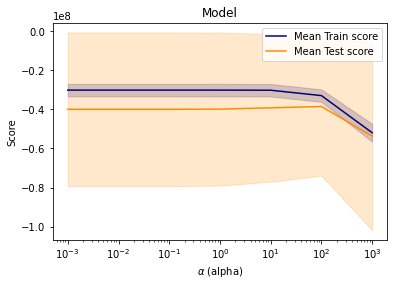

Best MSE: -38578380.76
Best Alpha:  {'alpha': 100.0}


In [27]:
ridge_params = {'alpha':np.logspace(-3, 3, 7)}
find_best_alpha(Ridge(), ridge_params)

# Final Model with Best Alpha

In [45]:
# fitting ridge with best alpha=100

model_ridge3 = Ridge(alpha=100)
model_ridge3.fit(X_PP, y_PP)
RIDGE_BEST = evaluate(model_ridge3, X_test=X_test_PP, y_test=y_test_PP, exp=False)

MemoryError: Unable to allocate 12.1 GiB for an array with shape (2030, 800437) and data type float64

# Summary of Result

In [47]:
# Model comparison 

df_conclusion = pd.DataFrame(columns=['MSE', 'MAE', 'R_Squared'])
df_conclusion = df_conclusion.append(pd.Series(list(LINEAR), index=df_conclusion.columns), ignore_index=True)
df_conclusion = df_conclusion.append(pd.Series(list(RIDGE), index=df_conclusion.columns), ignore_index=True)
df_conclusion = df_conclusion.append(pd.Series(list(RIDGE_BEST), index=df_conclusion.columns), ignore_index=True)
df_conclusion = df_conclusion.append(pd.Series(list(LASSO), index=df_conclusion.columns), ignore_index=True)
df_conclusion['Model'] = ['LINEAR', 'RIDGE','LASSO']
df_conclusion = df_conclusion[['Model', 'MSE', 'MAE', 'R_Squared']]
df_conclusion.set_index('Model', inplace=True)
display(df_conclusion)

,MSE,MAE,R_Squared
Model,,,
LINEAR,1.359817e+07,1057.921541,0.814883
RIDGE,1.360091e+07,1058.811013,0.814845
LASSO,1.428487e+07,1081.651878,0.805534


<AxesSubplot:xlabel='Model'>

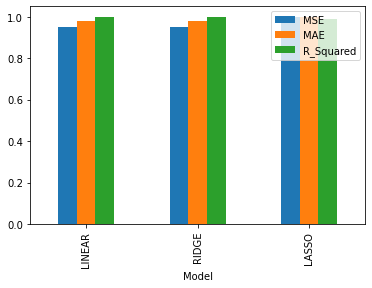

In [48]:
# THIS PLOT IS NORMALIZED
df_conclusion.apply(lambda x: x/x.max(), axis=0).plot(kind='bar')

In [ ]:
#LINEAR가 제일 점수가 높고 LASSO가 점수가 제일 낮았다.
하지만 전반적으로 R^2가 0.8 점 이상으로 높게 나와서 세 가지 모델 모두 예측력이 있다는 것을 알 수 있다.